<a href="https://colab.research.google.com/github/Radyko/MLQuantStrategy/blob/main/AlgorithminTradingUnsupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Done along with freeCodeCamp.org - Algorithmic Trading Course

In [147]:
!pip install pandas_ta

In [151]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-08-01'

start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df


[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-08-03 A        44.222775   47.090000   47.180000   46.900002   47.099998   
           AAL      32.271358   33.480000   33.959999   33.169998   33.470001   
           AAPL     24.263588   26.447500   26.459999   26.192499   26.202499   
           ABBV     47.158070   66.570000   67.000000   66.220001   66.809998   
           ABT      38.829494   44.950001   45.090000   44.830002   45.070000   
...                       ...         ...         ...         ...         ...   
2024-07-31 XYL     133.500000  133.500000  135.429993  132.600006  134.880005   
           YUM     132.830002  132.830002  134.029999  131.610001  132.759995   
           ZBH     111.349998  111.349998  113.080002  110.120003  111.510002   
           ZBRA    351.190002  351.190002  359.690002  348.989990  357.779999   
           ZTS     180.039993  180.039993  183.259995  179.830002  182.500000   

Price                   volume  
date       ticker               
2016-08-03 A         1508900.0  
           AAL       8254200.0  
           AAPL    120810400.0  
           ABBV      6355100.0  
           ABT       7783100.0  
...                        ...  
2024-07-31 XYL       2439500.0  
           YUM       1943100.0  
           ZBH       1592800.0  
           ZBRA       634400.0  
           ZTS       1740100.0  

[990317 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock.


*   Garman-Klass Volatility
*   RSI
*   Bollinger Bands
*   ATR
*   MACD
*   Dollar Volume

Garman Klass Volatility is an approximation used to measure intraday volatility of a given asset.

Garman-Klass Volatility = (((ln(High) - ln(Low))^2)/2) -(2ln(2)-1)(ln(Adj Close) - ln(Open))^2.


In [152]:

def calculate_bbands(x):
    bbands_result = pandas_ta.bbands(close=np.log1p(pd.Series(x)), length = 20)
    return bbands_result if bbands_result is not None else pd.DataFrame()  # Return an empty DataFrame if bbands_result is None
    #function needed, as iloc cannot work if input is None.




def compute_atr(stock_data):
  atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close = stock_data['close'], length = 14)
  return atr.sub(atr.mean()).div(atr.std())



def compute_macd(close):
  macd_result = pandas_ta.macd(close=close, length = 20)
  if macd_result is not None:  # Check if macd_result is not None
    macd = macd_result.iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
  else:
    return None  # Return None if macd_result is None

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)
df['bb_upper'] = df.groupby(level=1)['adj close'].transform(lambda x: calculate_bbands(x).iloc[:,2] if not calculate_bbands(x).empty else None)
df['bb_lower'] = df.groupby(level=1)['adj close'].transform(lambda x: calculate_bbands(x).iloc[:,0] if not calculate_bbands(x).empty else None)
df['bb_middle'] = df.groupby(level=1)['adj close'].transform(lambda x: calculate_bbands(x).iloc[:,1] if not calculate_bbands(x).empty else None)
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close']) - np.log(df['open']))**2)
df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length = 20))
pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length = 20)
df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6
#dollar volume in millions

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-08-03 A        44.222775   47.090000   47.180000   46.900002   47.099998   
           AAL      32.271358   33.480000   33.959999   33.169998   33.470001   
           AAPL     24.263588   26.447500   26.459999   26.192499   26.202499   
           ABBV     47.158070   66.570000   67.000000   66.220001   66.809998   
           ABT      38.829494   44.950001   45.090000   44.830002   45.070000   
...                       ...         ...         ...         ...         ...   
2024-07-31 XYL     133.500000  133.500000  135.429993  132.600006  134.880005   
           YUM     132.830002  132.830002  134.029999  131.610001  132.759995   
           ZBH     111.349998  111.349998  113.080002  110.120003  111.510002   
           ZBRA    351.190002  351.190002  359.690002  348.989990  357.779999   
           ZTS     180.039993  180.039993  183.259995  179.830002  182.500000   

Price                   volume       atr  bb_upper  bb_lower  bb_middle  \
date       ticker                                                         
2016-08-03 A         1508900.0       NaN       NaN       NaN        NaN   
           AAL       8254200.0       NaN       NaN       NaN        NaN   
           AAPL    120810400.0       NaN       NaN       NaN        NaN   
           ABBV      6355100.0       NaN       NaN       NaN        NaN   
           ABT       7783100.0       NaN       NaN       NaN        NaN   
...                        ...       ...       ...       ...        ...   
2024-07-31 XYL       2439500.0  1.892789  4.968247  4.888463   4.928355   
           YUM       1943100.0  0.721489  4.893712  4.838324   4.866018   
           ZBH       1592800.0 -0.568448  4.737703  4.666365   4.702034   
           ZBRA       634400.0  0.521713  5.851929  5.729809   5.790869   
           ZTS       1740100.0  0.716857  5.221715  5.159026   5.190371   

Price              garman_klass_vol      macd        rsi  dollar_volume  
date       ticker                                                        
2016-08-03 A              -0.001517       NaN        NaN      66.727744  
           AAL            -0.000237       NaN        NaN     266.374247  
           AAPL           -0.002231       NaN        NaN    2931.293766  
           ABBV           -0.046807       NaN        NaN     299.694248  
           ABT            -0.008564       NaN        NaN     302.213838  
...                             ...       ...        ...            ...  
2024-07-31 XYL             0.000182 -0.278173  44.378010     325.673250  
           YUM             0.000166 -0.686611  53.203270     258.101977  
           ZBH             0.000351  0.190412  52.383683     177.358278  
           ZBRA            0.000322  0.873963  67.599872     222.794938  
           ZTS             0.000107  0.688203  56.187626     313.287592  

[990317 rows x 14 columns]

#3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.



*  To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.


*  Calculate 5-year rolling average of dollar volume for each stock before filtering.








In [153]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1).dropna()

data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods = 12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending = False))

data = data[data['dollar_vol_rank'] < 150].drop(['dollar_vol_rank','dollar_volume'], axis = 1)

data

adj close       atr  bb_upper  bb_lower  bb_middle  \
date       ticker                                                        
2017-08-31 AAL      43.511295  0.379254  3.936447  3.741600   3.839023   
           AAPL     38.485271 -1.152032  3.677678  3.621129   3.649403   
           ABBV     55.412037 -1.528612  4.022875  3.944742   3.983809   
           ABT      45.090450 -1.352457  3.825750  3.773206   3.799478   
           ACN     117.201675 -1.340890  4.773213  4.746614   4.759914   
...                       ...       ...       ...       ...        ...   
2024-07-31 VZ       40.520000 -0.191153  3.770161  3.687073   3.728617   
           WFC      58.890114  0.633665  4.127037  4.063394   4.095216   
           WMT      68.639999  0.787756  4.281437  4.241554   4.261496   
           XOM     118.589996  0.597315  4.794615  4.716281   4.755448   
           ZTS     180.039993  0.716857  5.221715  5.159026   5.190371   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-08-31 AAL            -0.000146 -1.850155  37.643918  
           AAPL           -0.001422 -0.011288  65.283103  
           ABBV           -0.032460  0.061340  68.425774  
           ABT            -0.004445  0.070555  62.800458  
           ACN            -0.004114 -0.058479  59.510617  
...                             ...       ...        ...  
2024-07-31 VZ              0.000144 -0.152062  51.735733  
           WFC             0.000024  0.131169  50.270815  
           WMT             0.000074  0.648607  51.666269  
           XOM             0.000021  0.679436  57.851744  
           ZTS             0.000107  0.688203  56.187626  

[12516 rows x 8 columns]

# 4. Calculate Monthly Returns for different time horizons as features

*   To capture time series dynamics that reflect momentum patterns, we compute historical returns using the method .pct_change(lag), which shows returns over various montlhy periods as identified by lags.



In [154]:
def calculate_returns(df):

  outlier_cutoff = 0.005 #arbitrary

  lags = [1,2,3,6,9,12]

  for lag in lags:
    df[f'return_{lag}m'] = (df['adj close']
                          .pct_change(lag)
                          .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                          .add(1)
                          .pow(1/lag)
                          .sub(1))

  return df


data = data.groupby(level = 1, group_keys= False).apply(calculate_returns).dropna()

data

adj close       atr  bb_upper  bb_lower  bb_middle  \
date       ticker                                                        
2018-08-31 AAL      39.726204  0.003666  3.727116  3.603652   3.665384   
           AAPL     54.224758 -0.998122  4.007320  3.896835   3.952077   
           ABBV     73.114143 -0.645670  4.340413  4.287913   4.314163   
           ABT      60.295731 -1.228504  4.127625  4.055374   4.091499   
           ACN     154.357269 -1.118371  5.053630  4.977965   5.015797   
...                       ...       ...       ...       ...        ...   
2024-07-31 VRTX    495.720001  1.373761  6.225542  6.165930   6.195736   
           VZ       40.520000 -0.191153  3.770161  3.687073   3.728617   
           WFC      58.890114  0.633665  4.127037  4.063394   4.095216   
           WMT      68.639999  0.787756  4.281437  4.241554   4.261496   
           XOM     118.589996  0.597315  4.794615  4.716281   4.755448   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-08-31 AAL            -0.000024  0.718918  55.978016   0.026445   
           AAPL           -0.000647  0.434839  81.062410   0.200422   
           ABBV           -0.029147  0.023125  49.722354   0.040659   
           ABT            -0.004198  0.428158  64.178322   0.019835   
           ACN            -0.003021  0.181194  63.975245   0.061131   
...                             ...       ...        ...        ...   
2024-07-31 VRTX            0.000114  1.324232  62.146045   0.057604   
           VZ              0.000144 -0.152062  51.735733  -0.001379   
           WFC             0.000024  0.131169  50.270815  -0.000842   
           WMT             0.000074  0.648607  51.666269   0.013735   
           XOM             0.000021  0.679436  57.851744   0.030142   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-08-31 AAL      0.034006  -0.023150  -0.046843  -0.023509   -0.007555  
           AAPL     0.110862   0.069228   0.043001   0.033036    0.028984  
           ABBV     0.022996  -0.006715  -0.027534   0.001987    0.023371  
           ABT      0.049211   0.029514   0.018801   0.020703    0.024511  
           ACN      0.016611   0.027753   0.009652   0.015882    0.023213  
...                      ...        ...        ...        ...         ...  
2024-07-31 VRTX     0.043399   0.080649   0.022652   0.035512    0.028860  
           VZ       0.000402   0.014092  -0.001977   0.021535    0.020476  
           WFC     -0.004852   0.002025   0.030523   0.047980    0.023656  
           WMT      0.021663   0.050878   0.038538   0.027229    0.022525  
           XOM      0.005655   0.003604   0.027048   0.015688    0.011331  

[10369 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas



*   We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression.
*   The five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown to imperically explain asset returns in the past and are commonly used to asses the risk/return profile of portfolios.
*   We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.





In [155]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = '2010')[0].drop('RF', axis =1)
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data



Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-08-31 AAL     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.026445
           AAPL    0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.200422
           ABBV    0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.040659
           ABT     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.019835
           ACN     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.061131
...                   ...     ...     ...     ...     ...        ...
2024-06-30 VRTX    0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029385
           VZ      0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.002187
           WFC     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.008845
           WMT     0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029653
           XOM     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.018250

[10227 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [156]:
observations = factor_data.groupby(level = 1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-08-31 AAL     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.026445
           AAPL    0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.200422
           ABBV    0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.040659
           ABT     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.019835
           ACN     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.061131
...                   ...     ...     ...     ...     ...        ...
2024-06-30 VRTX    0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029385
           VZ      0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.002187
           WFC     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.008845
           WMT     0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029653
           XOM     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.018250

[10198 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [157]:
betas = (factor_data.groupby(level=1,
                      group_keys=False)
    .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                exog = sm.add_constant(x.drop('return_1m', axis = 1)),
                                window= min(24, x.shape[0]),
                                min_nobs=len(x.columns)+1)
    .fit(params_only = True)
    .params
    .drop('const', axis = 1)))

betas


Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-08-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-06-30 VRTX    0.489479  0.498689 -0.378682  0.472388  0.418508
           VZ      0.646520 -1.234067  0.594019 -0.054805 -0.053215
           WFC     1.021368  0.344371  1.209067 -0.499866 -0.755414
           WMT     0.480750  0.179871 -0.134151  0.935790  0.005896
           XOM     0.742724  0.043761  0.430496  0.839708  0.497997

[10198 rows x 5 columns]

In [159]:
factors = ['Mkt-RF',	'SMB',	'HML',	'RMW',	'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))


data = data.drop('adj close', axis = 1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10159 entries, (Timestamp('2018-08-31 00:00:00'), 'AAL') to (Timestamp('2024-07-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10159 non-null  float64
 1   bb_upper          10159 non-null  float64
 2   bb_lower          10159 non-null  float64
 3   bb_middle         10159 non-null  float64
 4   garman_klass_vol  10159 non-null  float64
 5   macd              10159 non-null  float64
 6   rsi               10159 non-null  float64
 7   return_1m         10159 non-null  float64
 8   return_2m         10159 non-null  float64
 9   return_3m         10159 non-null  float64
 10  return_6m         10159 non-null  float64
 11  return_9m         10159 non-null  float64
 12  return_12m        10159 non-null  float64
 13  Mkt-RF            10159 non-null  float64
 14  SMB               10159 non-null  float64
 15  HML        

# 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

###K-Means Clustering

* You may want to initialize predefined centroids for each cluster based on your research.
* For visualization purpose, we will initially rely on the 'k-means++' initialization.
* Then we will pre-define our centroids for each cluster.

In [160]:
!pip install scikit-learn

In [161]:
from sklearn.cluster import KMeans

def get_clusters(df):
  df['cluster'] = KMeans(n_clusters=4,
                         random_state=0,
                         init= 'random').fit(df).labels_

  return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data



atr  bb_upper  bb_lower  bb_middle  garman_klass_vol  \
date       ticker                                                              
2018-08-31 AAL     0.003666  3.727116  3.603652   3.665384         -0.000024   
           AAPL   -0.998122  4.007320  3.896835   3.952077         -0.000647   
           ABBV   -0.645670  4.340413  4.287913   4.314163         -0.029147   
           ABT    -1.228504  4.127625  4.055374   4.091499         -0.004198   
           ACN    -1.118371  5.053630  4.977965   5.015797         -0.003021   
...                     ...       ...       ...        ...               ...   
2024-07-31 VRTX    1.373761  6.225542  6.165930   6.195736          0.000114   
           VZ     -0.191153  3.770161  3.687073   3.728617          0.000144   
           WFC     0.633665  4.127037  4.063394   4.095216          0.000024   
           WMT     0.787756  4.281437  4.241554   4.261496          0.000074   
           XOM     0.597315  4.794615  4.716281   4.755448          0.000021   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-08-31 AAL     0.718918  55.978016   0.026445   0.034006  -0.023150   
           AAPL    0.434839  81.062410   0.200422   0.110862   0.069228   
           ABBV    0.023125  49.722354   0.040659   0.022996  -0.006715   
           ABT     0.428158  64.178322   0.019835   0.049211   0.029514   
           ACN     0.181194  63.975245   0.061131   0.016611   0.027753   
...                     ...        ...        ...        ...        ...   
2024-07-31 VRTX    1.324232  62.146045   0.057604   0.043399   0.080649   
           VZ     -0.152062  51.735733  -0.001379   0.000402   0.014092   
           WFC     0.131169  50.270815  -0.000842  -0.004852   0.002025   
           WMT     0.648607  51.666269   0.013735   0.021663   0.050878   
           XOM     0.679436  57.851744   0.030142   0.005655   0.003604   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-08-31 AAL     -0.046843  -0.023509   -0.007555  1.196315  1.549052   
           AAPL     0.043001   0.033036    0.028984  1.316170 -0.321337   
           ABBV    -0.027534   0.001987    0.023371  0.485092  0.480214   
           ABT      0.018801   0.020703    0.024511  0.781188 -0.119182   
           ACN      0.009652   0.015882    0.023213  1.211913 -0.193749   
...                      ...        ...         ...       ...       ...   
2024-07-31 VRTX     0.022652   0.035512    0.028860  0.496569  0.091185   
           VZ      -0.001977   0.021535    0.020476  0.467068 -0.466544   
           WFC      0.030523   0.047980    0.023656  1.092799 -0.083007   
           WMT      0.038538   0.027229    0.022525  0.622336 -0.384151   
           XOM      0.027048   0.015688    0.011331  1.060773  0.125057   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-08-31 AAL     0.360924  0.247544  0.815968        0  
           AAPL   -0.627418  0.418829  0.611568        1  
           ABBV   -0.209061  0.527852  0.506663        0  
           ABT    -0.429838  0.217202  0.932033        3  
           ACN    -0.257581  0.345706  0.080547        3  
...                     ...       ...       ...      ...  
2024-07-31 VRTX   -0.866394  0.130570  0.841082        2  
           VZ      0.249814  0.166819  0.191334        0  
           WFC     1.560665 -0.706349 -0.887796        0  
           WMT    -0.370371  0.197579  0.681620        0  
           XOM     0.869373 -0.502338  0.402534        2  

[10159 rows x 19 columns]

In [162]:
def plot_clusters(data):
  cluster_0 = data[data['cluster']==0]
  cluster_1 = data[data['cluster']==1]
  cluster_2 = data[data['cluster']==2]
  cluster_3 = data[data['cluster']==3]

  plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color = 'red', label = 'cluster 0')
  plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color = 'green', label = 'cluster 1')
  plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color = 'blue', label = 'cluster 2')
  plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color = 'black', label = 'cluster 3')

  plt.legend()
  plt.show()
  return


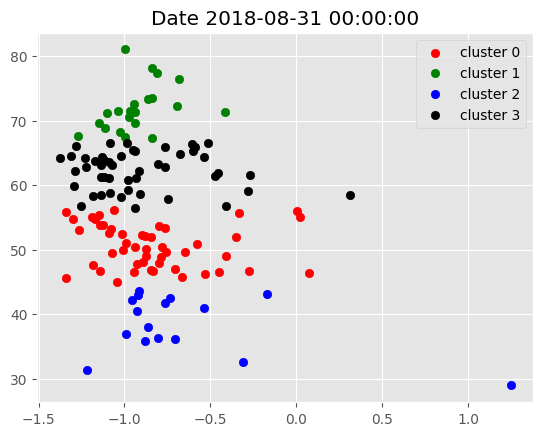

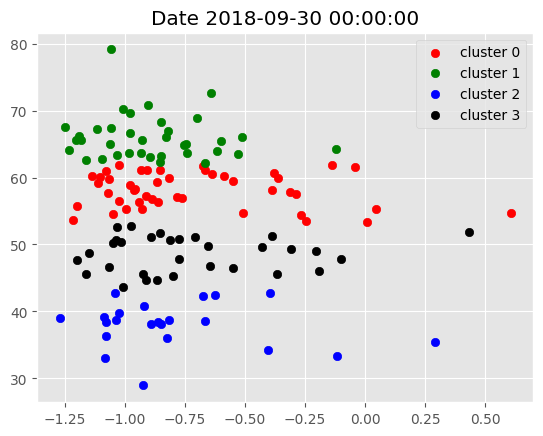

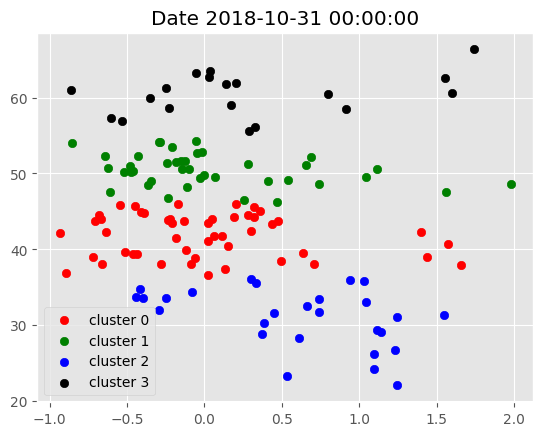

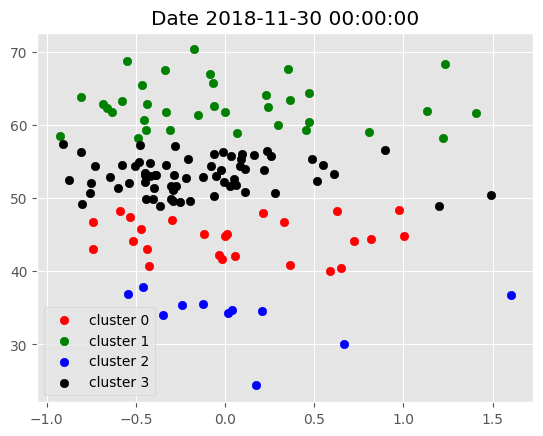

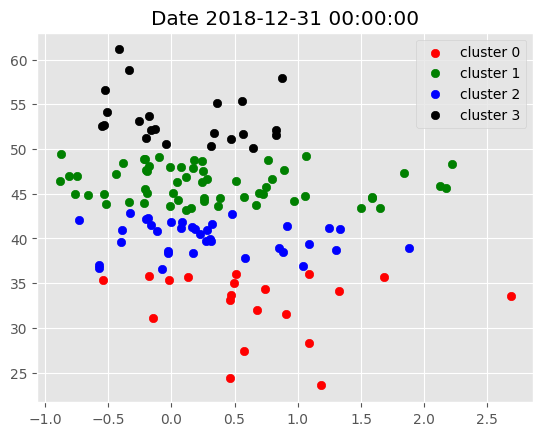

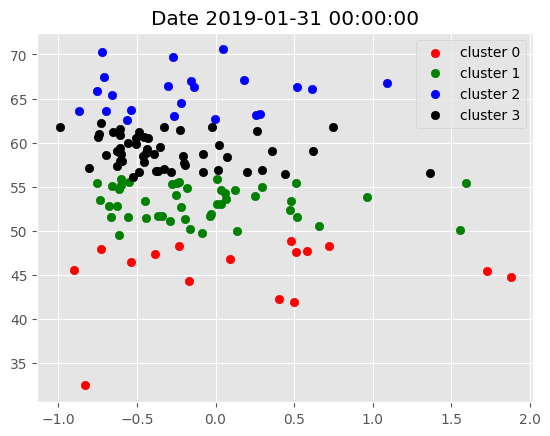

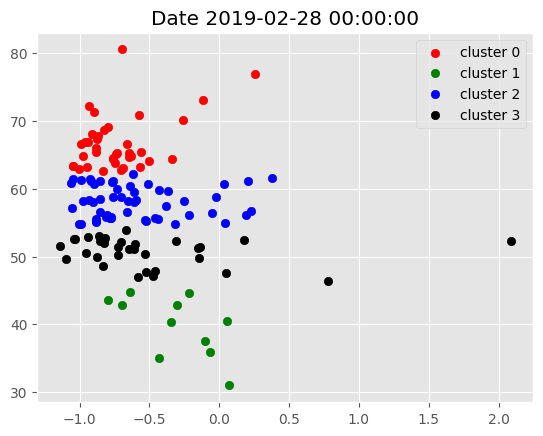

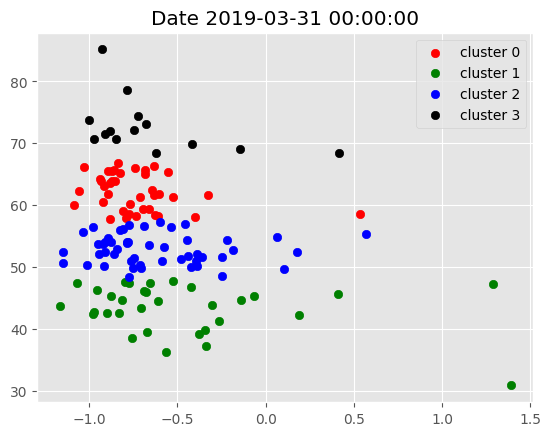

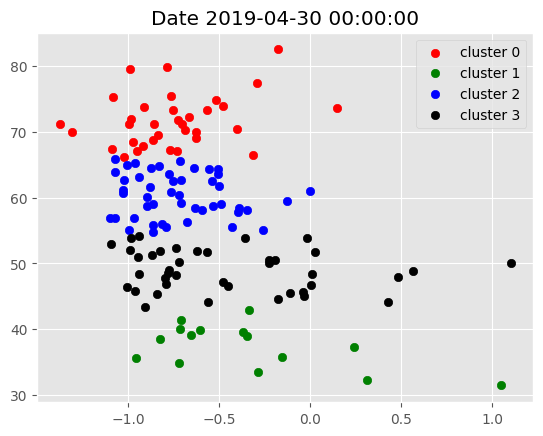

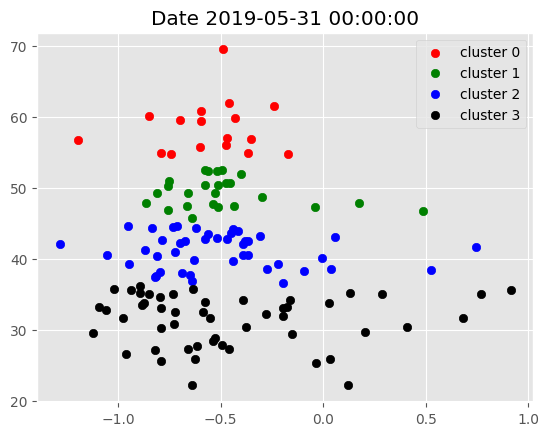

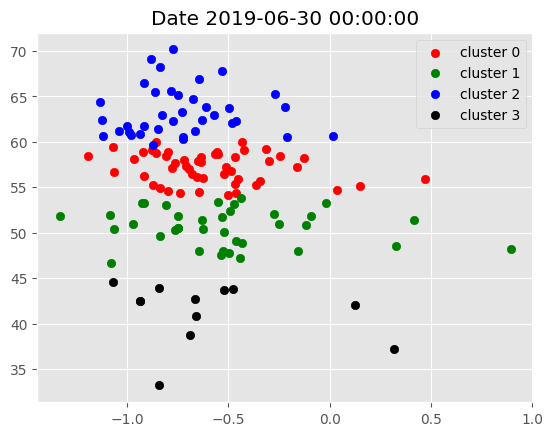

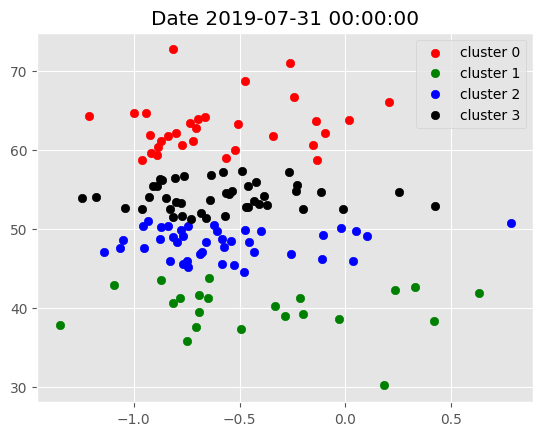

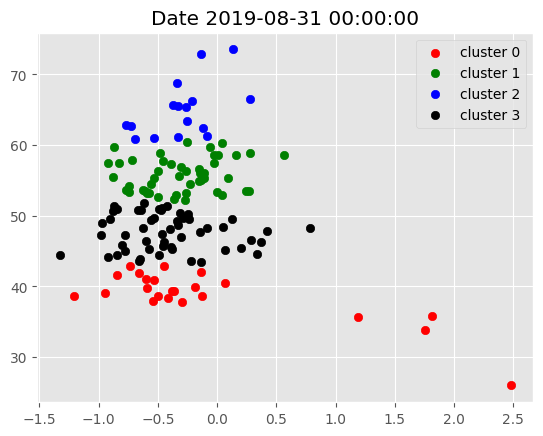

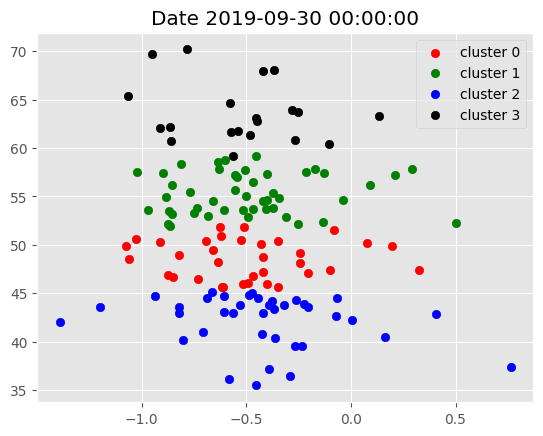

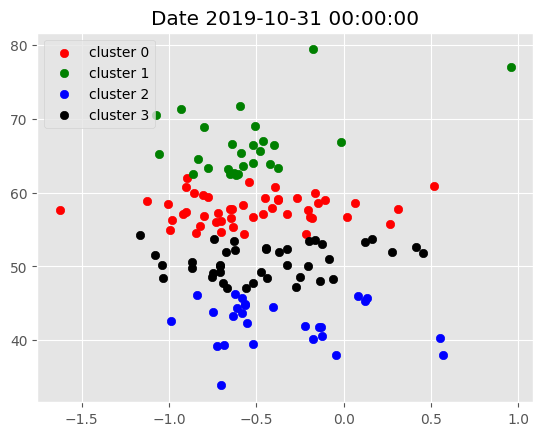

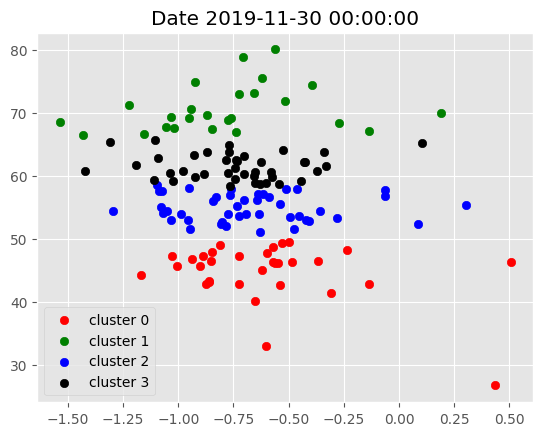

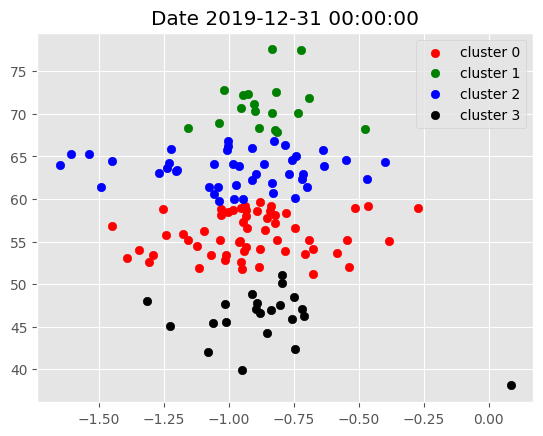

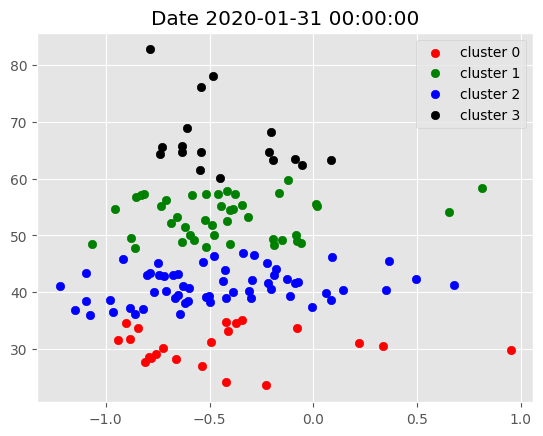

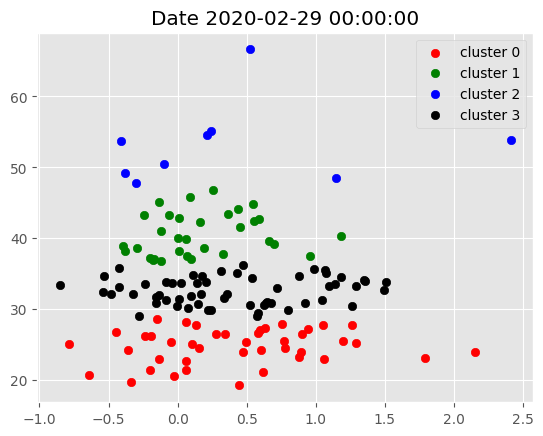

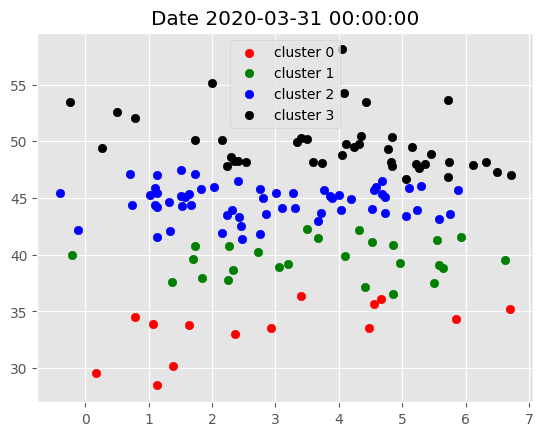

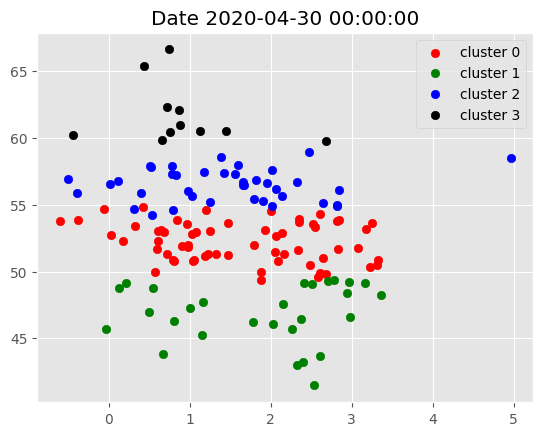

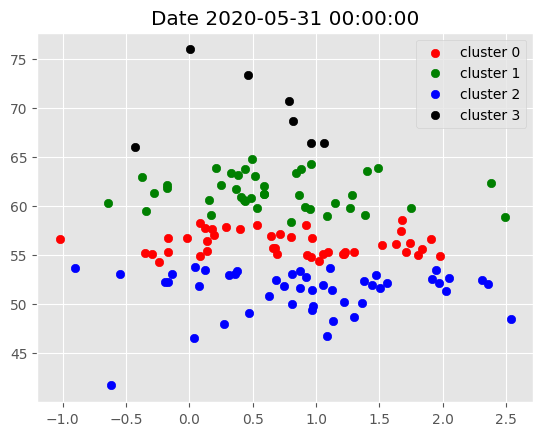

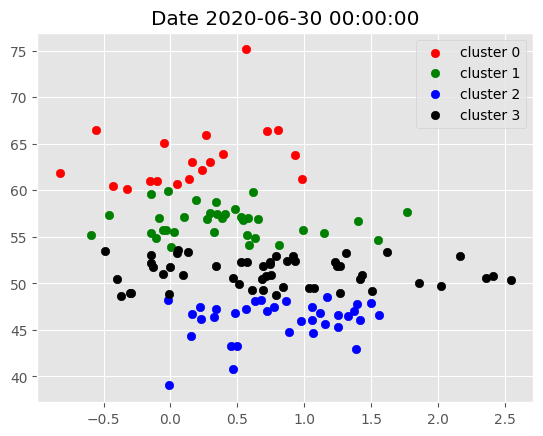

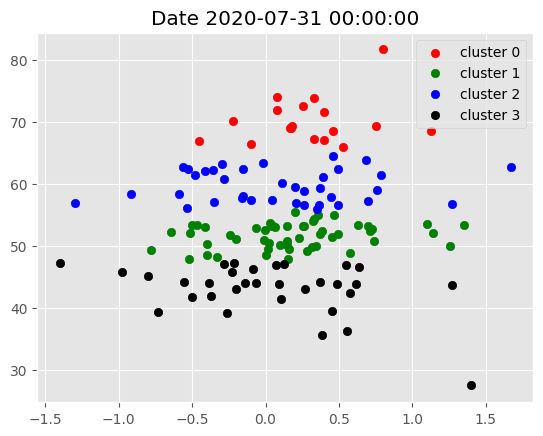

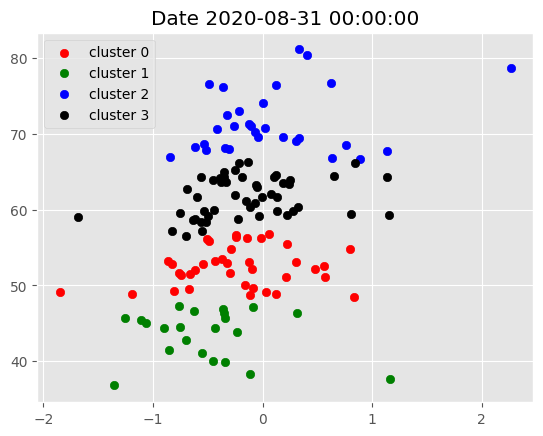

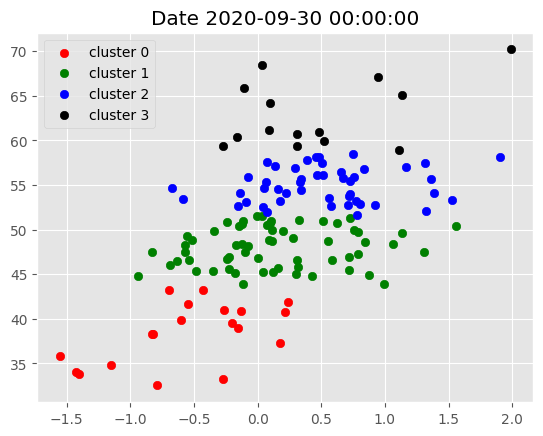

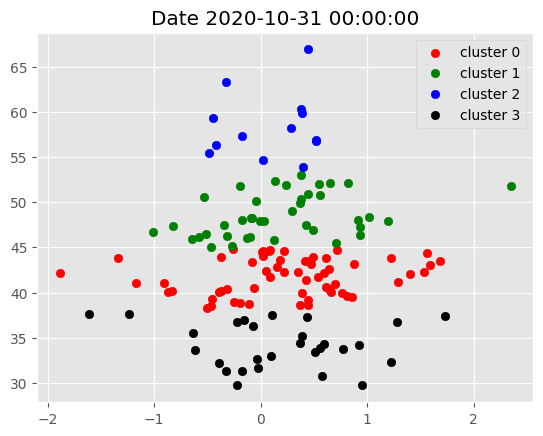

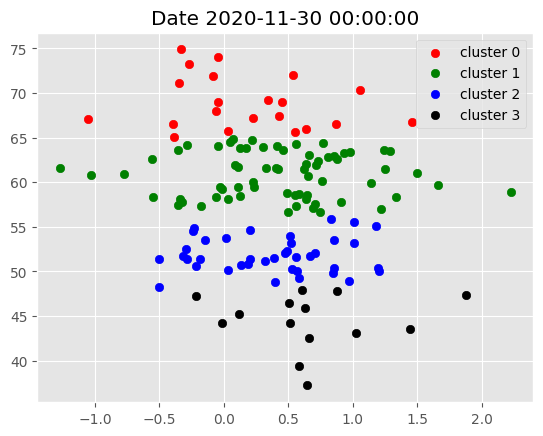

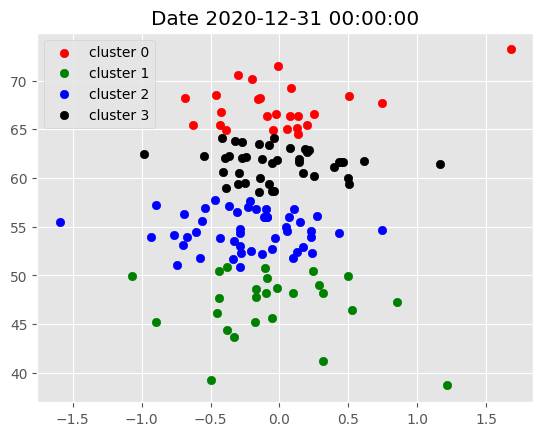

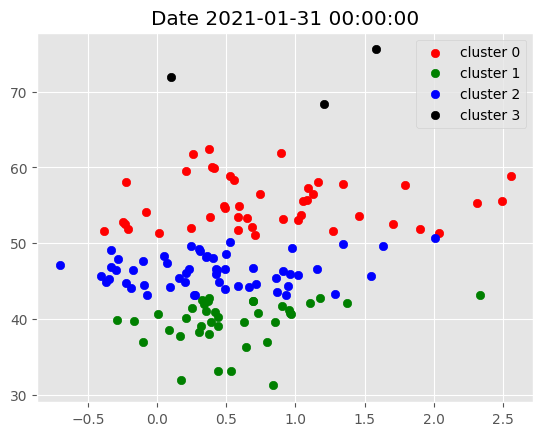

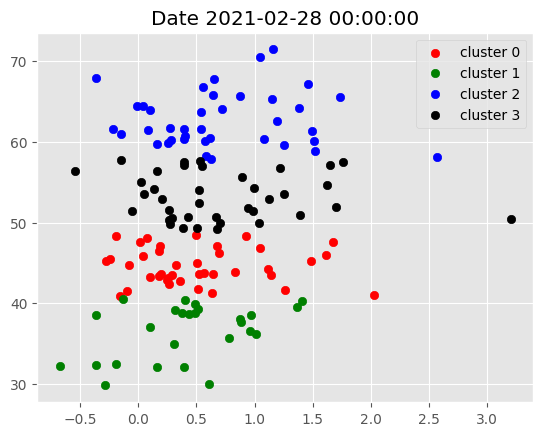

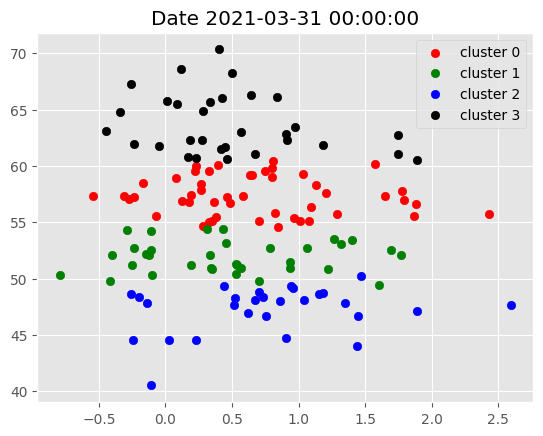

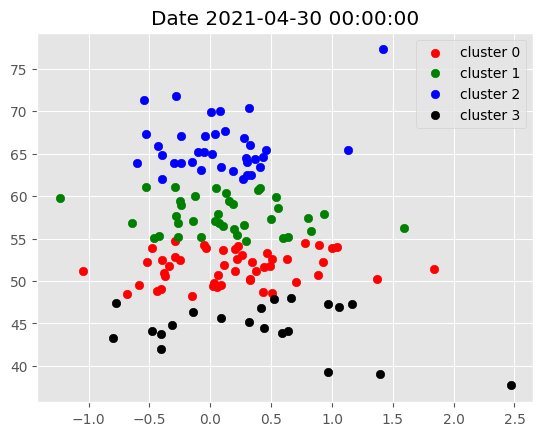

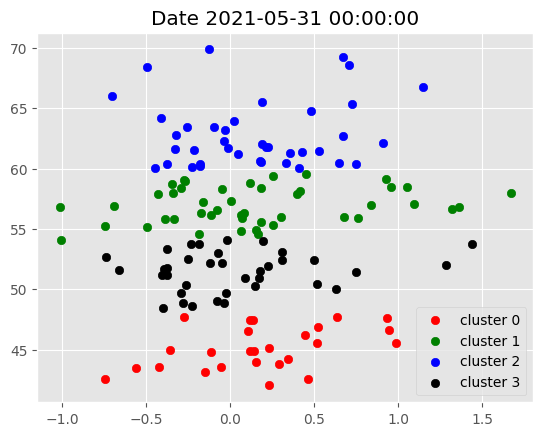

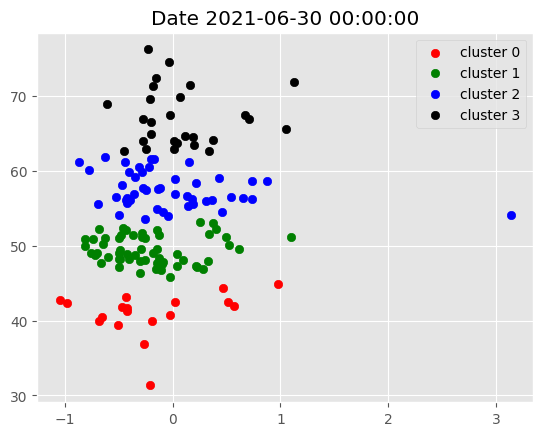

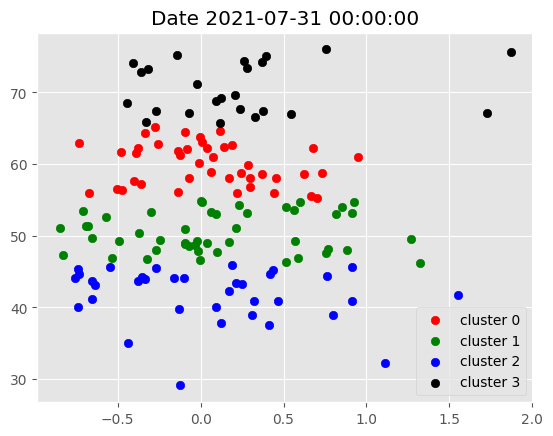

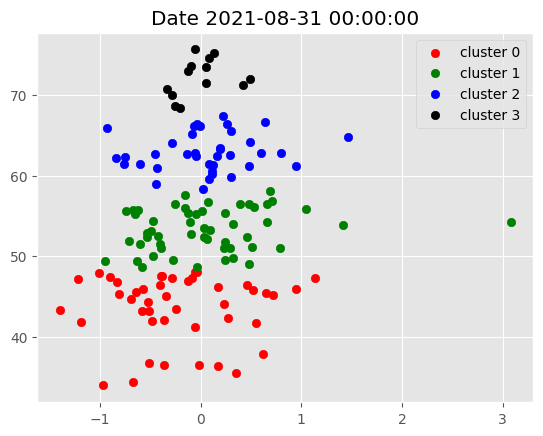

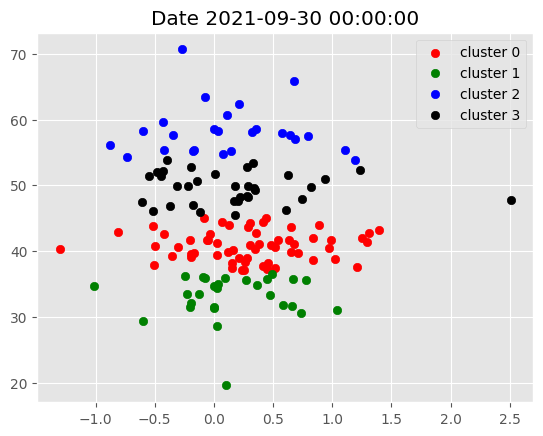

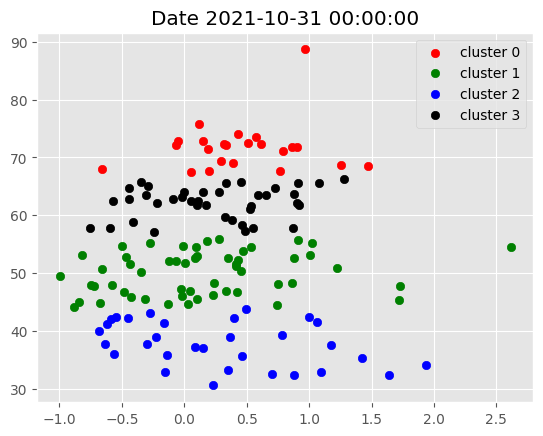

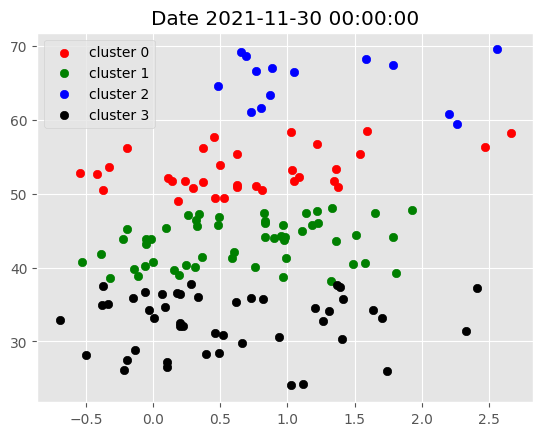

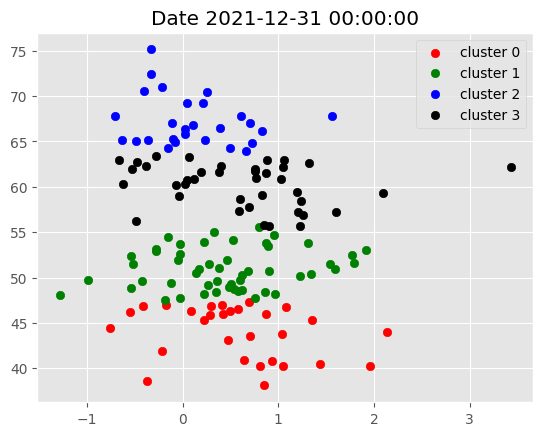

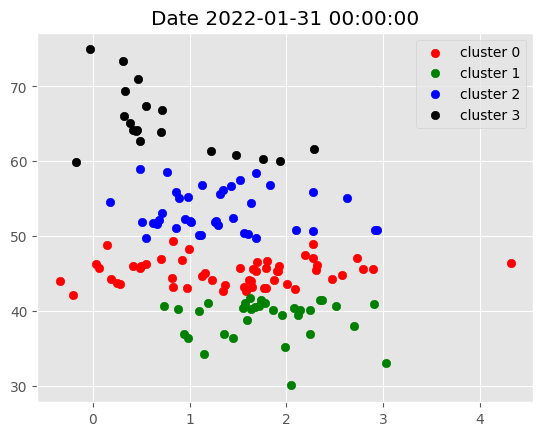

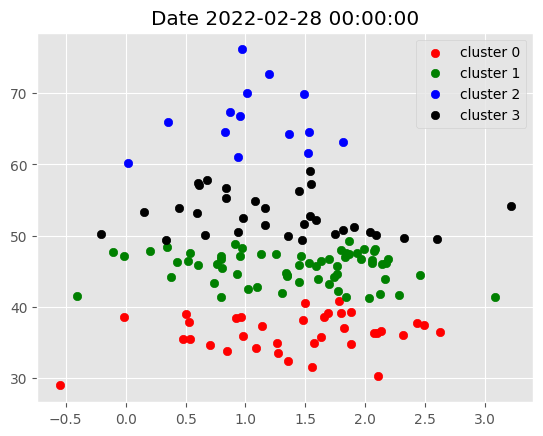

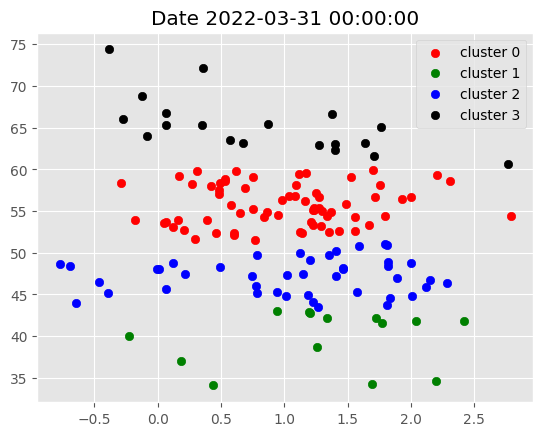

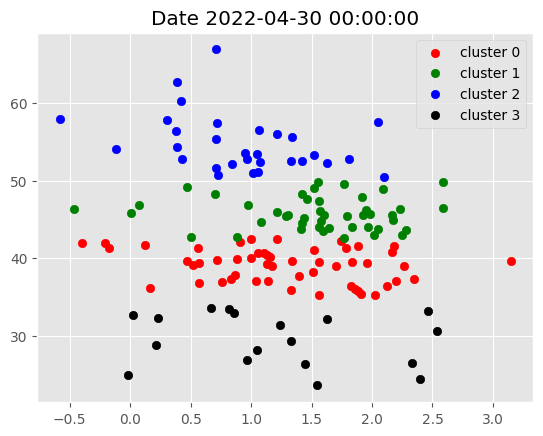

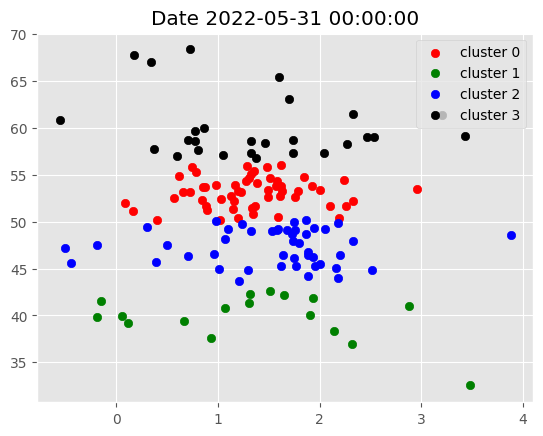

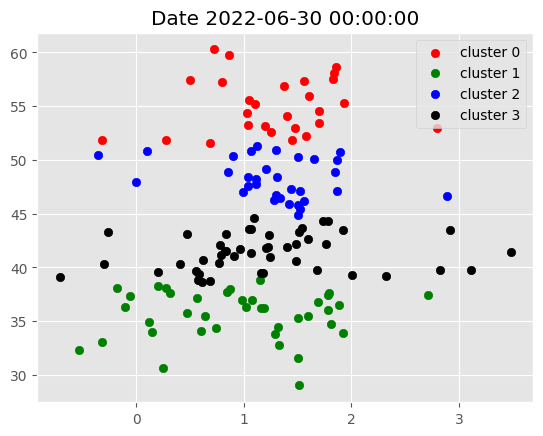

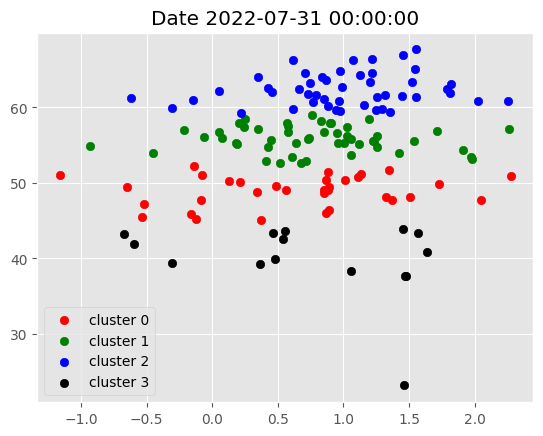

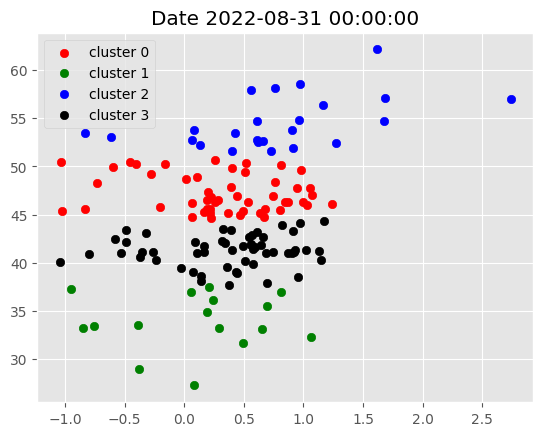

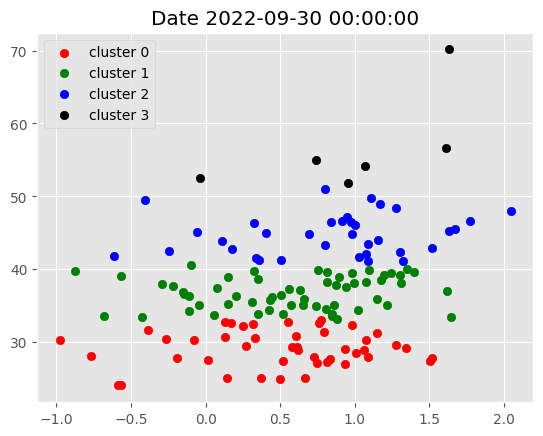

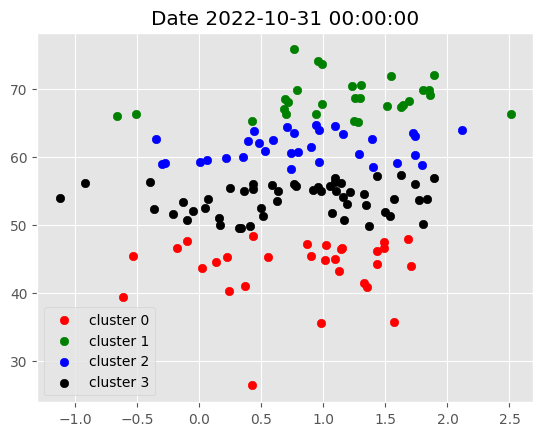

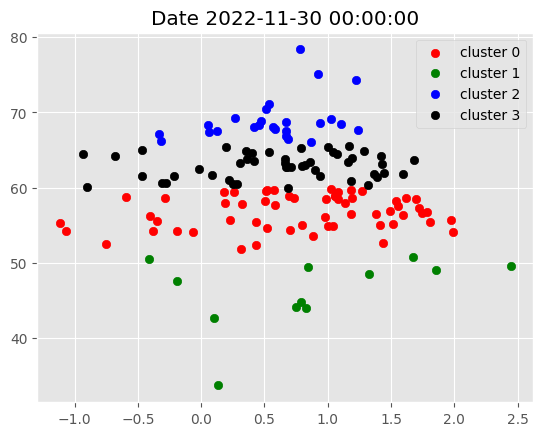

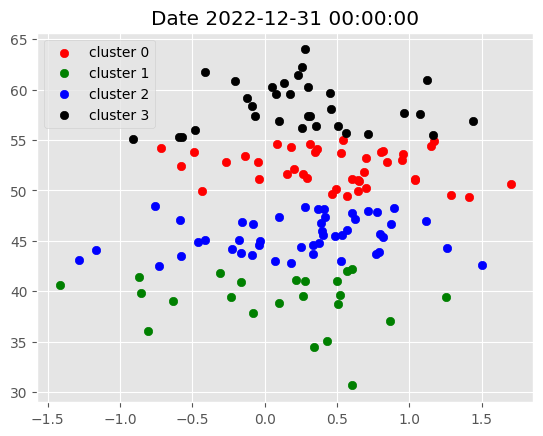

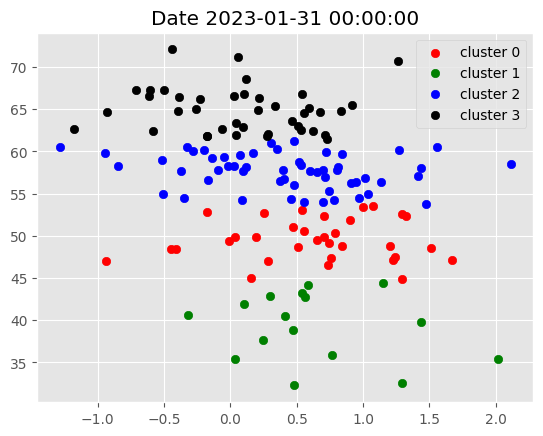

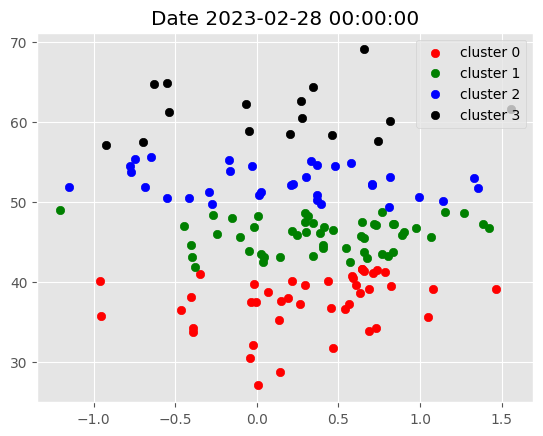

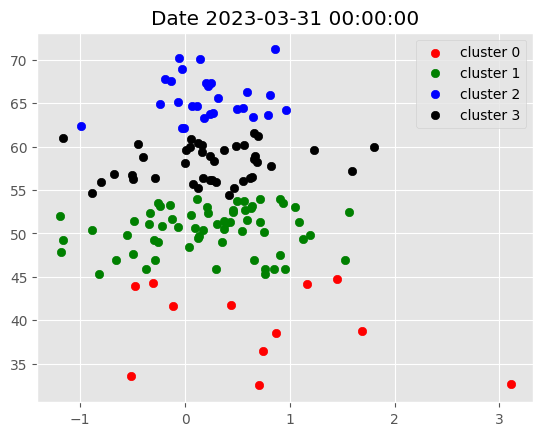

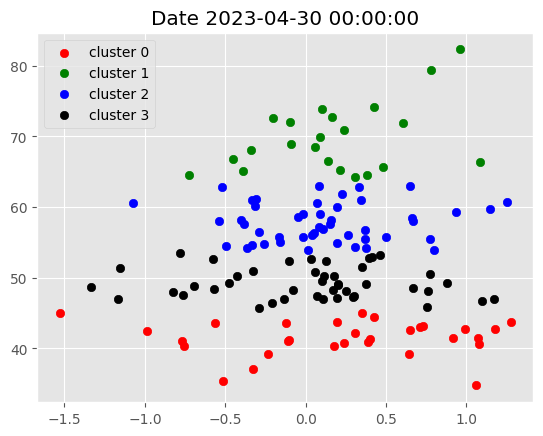

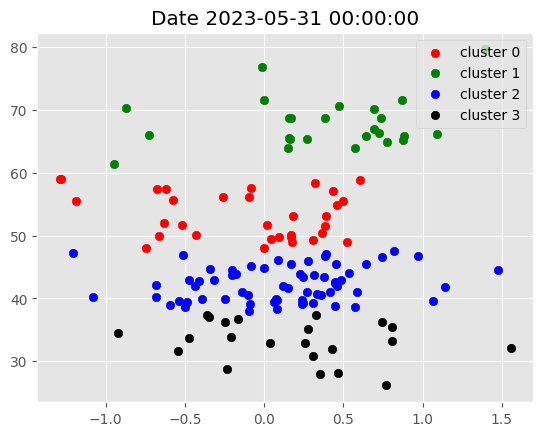

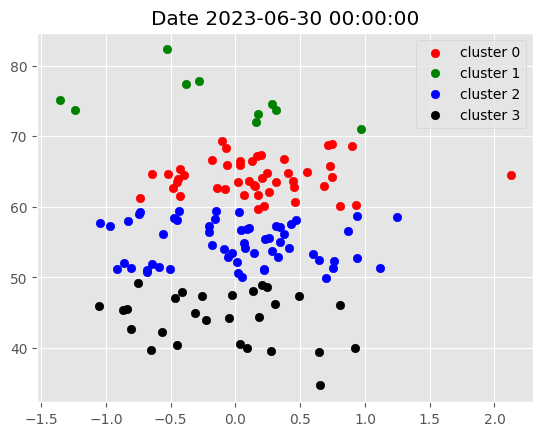

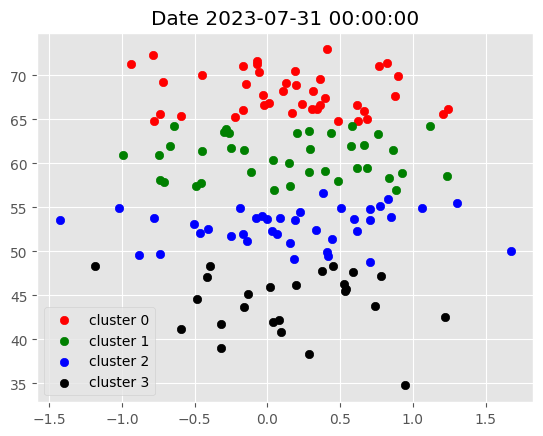

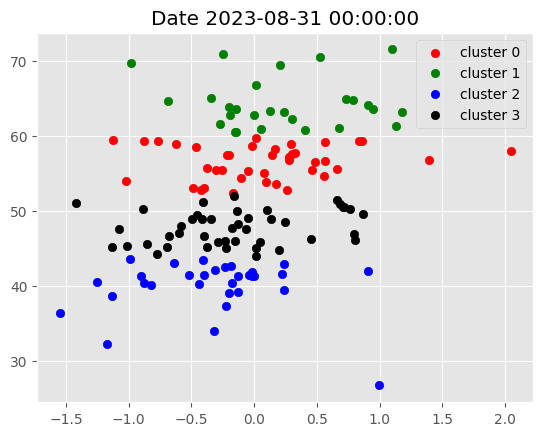

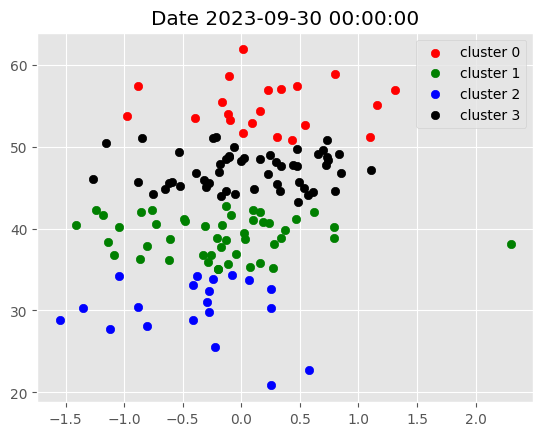

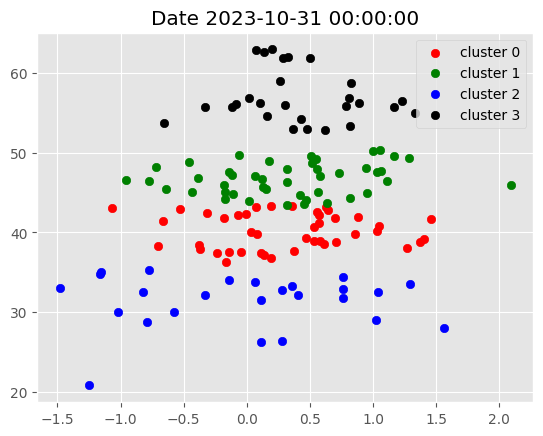

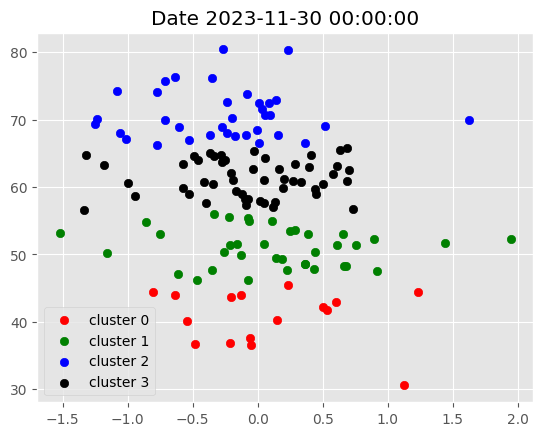

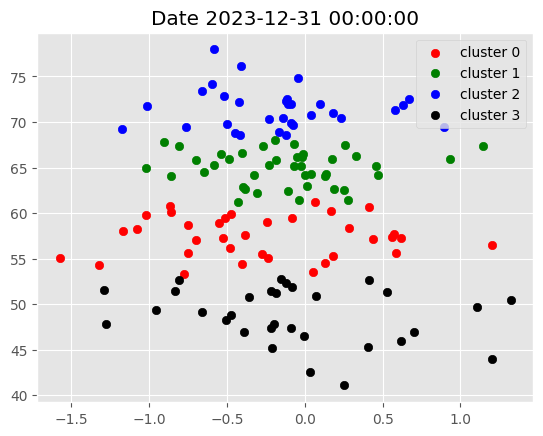

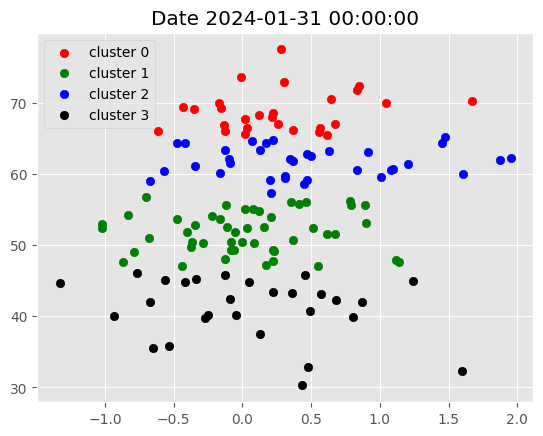

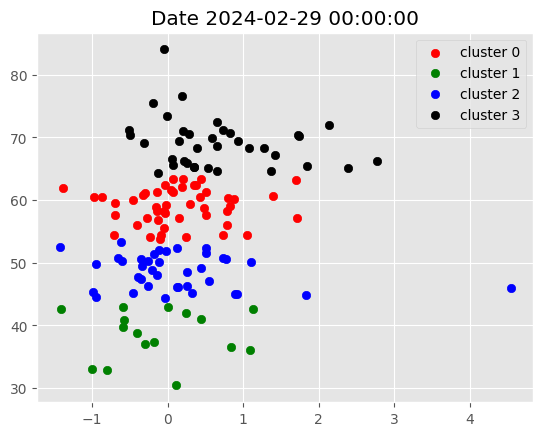

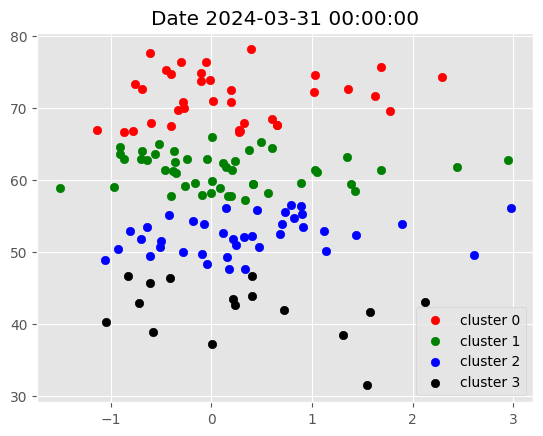

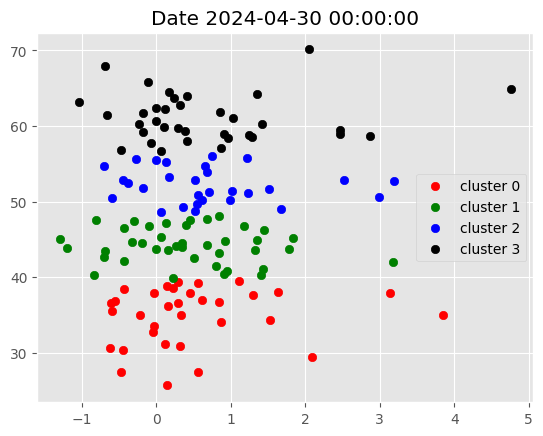

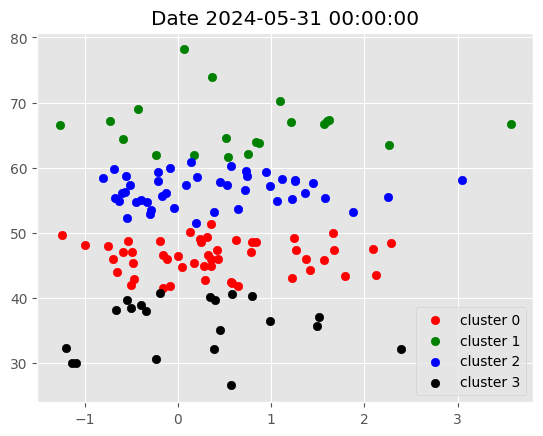

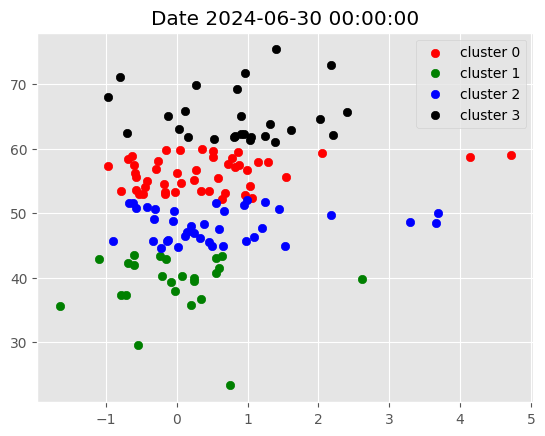

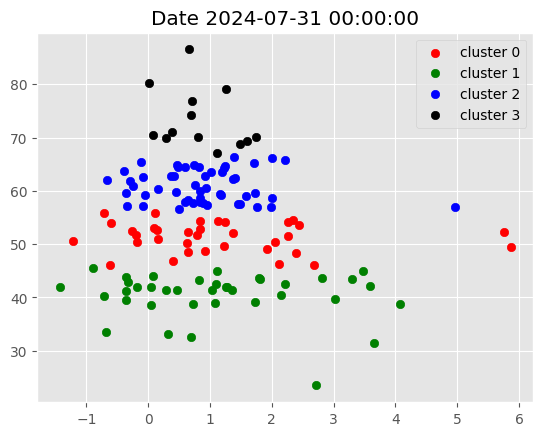

In [163]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

  g = data.xs(i,level =0)

  plt.title(f'Date {i}')

  plot_clusters(g)
